In [16]:
import ctypes
libgcc_s = ctypes.CDLL('libgcc_s.so.1')
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/avic/OOD_Orientation_Generalization')
from my_dataclasses import *
from train.dataset import *
from train.train import *
from numpy.random import choice
import tools
import seaborn as sns
from pandas.api.types import CategoricalDtype
import itertools
import functools
from sklearn.preprocessing import normalize
from matplotlib_venn import *

In [9]:
ExpData.get_experiments(319).training_category

'SM'

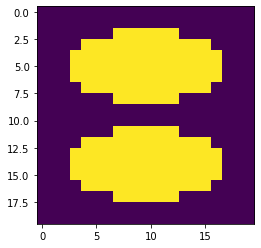

In [2]:
analytical_heatmap = np.load('canonical_z_unrestricted_heatmap.npy')

fig8 = np.mean((analytical_heatmap[0] * 0.5) + (analytical_heatmap[1] * 5), axis=2) < 5

plt.imshow(fig8)

xs, ys, zs = tools.get_heatmap_cell_ranges2(20)

cubelet_ranges = np.array(list(itertools.product(np.stack([xs[:-1], xs[1:]]).T, np.stack([ys[:-1], ys[1:]]).T))).reshape(20, 20, 2, 2)

fig8_ranges = cubelet_ranges[fig8]

In [ ]:
all_data = None
for x in range(4):
    e = ExpData.get_experiments(x)

    image_activations = np.load(e.image_activations)

    rd = RotationDataset(e)
    df = pd.read_csv(rd.testing.full.path.merged_annotation_path())
    df['model_code'] = df.model_name.astype(CategoricalDtype(categories=df.model_name.unique(),ordered=True)).cat.codes

    in_hole = functools.reduce(lambda a, b: a | (df.object_x.between(*b[0]) & df.object_y.between(*b[1])), fig8_ranges, df.object_x > 10)

    df['in_hole'] = in_hole

    norm_image_activations = image_activations / np.max(image_activations, axis=0)

    THRESHOLD = 0.2

    pre_transformed_activations = np.zeros((50, 512))
    for name, group in df[df.object_x.between(-0.25, 0.25) & df.object_y.between(-0.25, 0.25)].groupby('model_name'):
        pre_transformed_activations[group.model_code.iloc[0]] = np.mean(norm_image_activations[group.index], axis=0)

    pre_transformed_activations_per_image = pre_transformed_activations[df.model_code]

    image_invariances = 1 - np.abs((norm_image_activations - pre_transformed_activations_per_image) / (norm_image_activations + pre_transformed_activations_per_image))

    image_invariances_thresholded = np.where((norm_image_activations > THRESHOLD) | (pre_transformed_activations_per_image > THRESHOLD), image_invariances, np.nan)

    outside_bin = ~(df.object_x.between(-0.25, 0.25) & df.object_y.between(-0.25, 0.25))

    training_8_invariances = image_invariances_thresholded[np.where(df.model_name.isin(rd.training_models) & ~df.in_hole & outside_bin)]
    testing_8_invariances = image_invariances_thresholded[np.where(df.model_name.isin(rd.testing_models) & ~df.in_hole & outside_bin)]

    training_hole_invariances = image_invariances_thresholded[np.where(df.model_name.isin(rd.training_models) & df.in_hole & outside_bin)]
    testing_hole_invariances = image_invariances_thresholded[np.where(df.model_name.isin(rd.testing_models) & df.in_hole & outside_bin)]

    iterables = [range(512), ['training', 'testing']]
    data = pd.MultiIndex.from_product(iterables, names=["neuron", "model_type"]).to_frame(name=['fig8', 'hole'])
    data.fig8 = np.vstack(np.array([np.nanmean(training_8_invariances, axis=0), np.nanmean(testing_8_invariances, axis=0)])).T.flatten()
    data.hole = np.vstack(np.array([np.nanmean(training_hole_invariances, axis=0), np.nanmean(testing_hole_invariances, axis=0)])).T.flatten()

    melted_data = data.melt(value_vars=['fig8', 'hole'], var_name='pattern', value_name='invariance', ignore_index=False).reset_index()
    melted_data['#seen'] = e.data_div
    if all_data is None:
        all_data = melted_data
    else:
        all_data = all_data.append(melted_data)
    print(f'done {x}')

In [ ]:
sns.catplot(kind='violin', data=all_data, col='#seen', x='pattern', y='invariance', split=True, hue='model_type', )

In [82]:
def fs(x):
    return set(np.argwhere(x).flatten())

results = []

for x in range(4):
    e = ExpData.get_experiments(x)
    image_activations = np.load(e.image_activations)
    rd = RotationDataset(e)
    df = pd.read_csv(rd.testing.full.path.merged_annotation_path())
    df['model_code'] = df.model_name.astype(CategoricalDtype(categories=df.model_name.unique(),ordered=True)).cat.codes
    norm_image_activations = image_activations / np.max(image_activations, axis=0)
    in_hole = functools.reduce(lambda a, b: a | (df.object_x.between(*b[0]) & df.object_y.between(*b[1])), fig8_ranges, df.object_x > 10)
    df['in_bin'] = df.object_x.between(-0.25, 0.25) & df.object_y.between(-0.25, 0.25)
    df['in_hole'] = in_hole

    neural_cat_activations = np.zeros((3, 50, 512))
    for name, group in df.groupby('model_name'):
        neural_cat_activations[0, group.model_code.iloc[0]] = np.mean(norm_image_activations[group[group.in_bin].index], axis=0)
        neural_cat_activations[1, group.model_code.iloc[0]] = np.mean(norm_image_activations[group[~group.in_bin & ~group.in_hole].index], axis=0)
        neural_cat_activations[2, group.model_code.iloc[0]] = np.mean(norm_image_activations[group[~group.in_bin & group.in_hole].index], axis=0)

    neural_cat_activations = neural_cat_activations.reshape(150, 512)
    norm_activity = neural_cat_activations / np.max(neural_cat_activations, axis=0)

    selectivity = norm_activity > 0.8
    selectivity = selectivity.reshape(3, 50, 512)

    f = np.any(selectivity[:,:40], axis=1)
    r = np.any(selectivity[:,40:], axis=1)

    fb, f8, fh = [fs(x) for x in f]
    rb, r8, rh = [fs(x) for x in r]

    b = fs(f[0] | r[0])
    fig8 = fs(f[1] | r[1])
    h = fs(f[2] | r[2])

    results.append({'fb':fb, 'f8':f8, 'fh':fh, 'rb':rb, 'r8':r8, 'rh':rh, 'b':b, 'fig8':fig8, 'h':h})

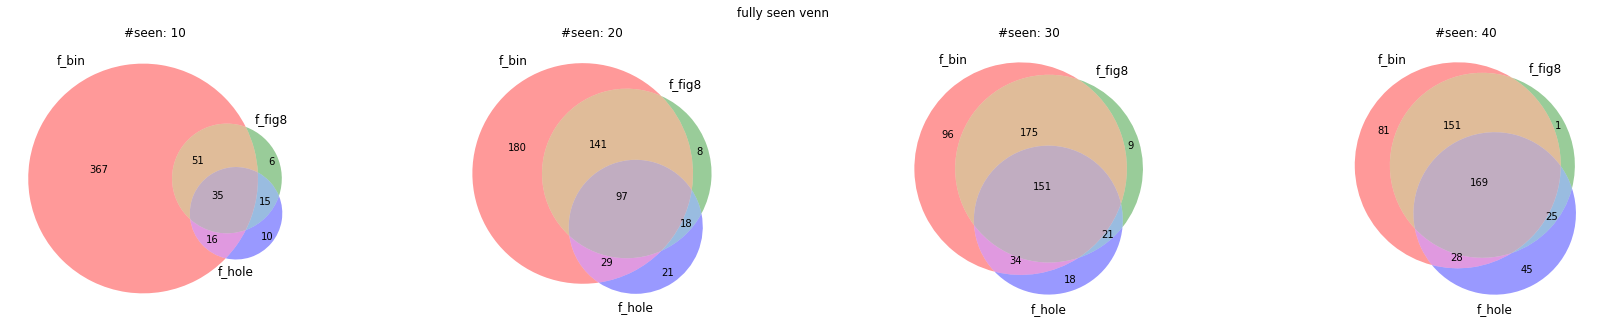

In [94]:
plt.close('all')
fig, axes = plt.subplots(1, 4, figsize=(30, 5))
fig.suptitle('fully seen venn')
for x in range(4):
    res = results[x]
    venn3([res['fb'], res['f8'], res['fh']], set_labels=['f_bin', 'f_fig8', 'f_hole'], ax=axes[x])
    axes[x].set(title=f'#seen: {(x + 1) * 10}')

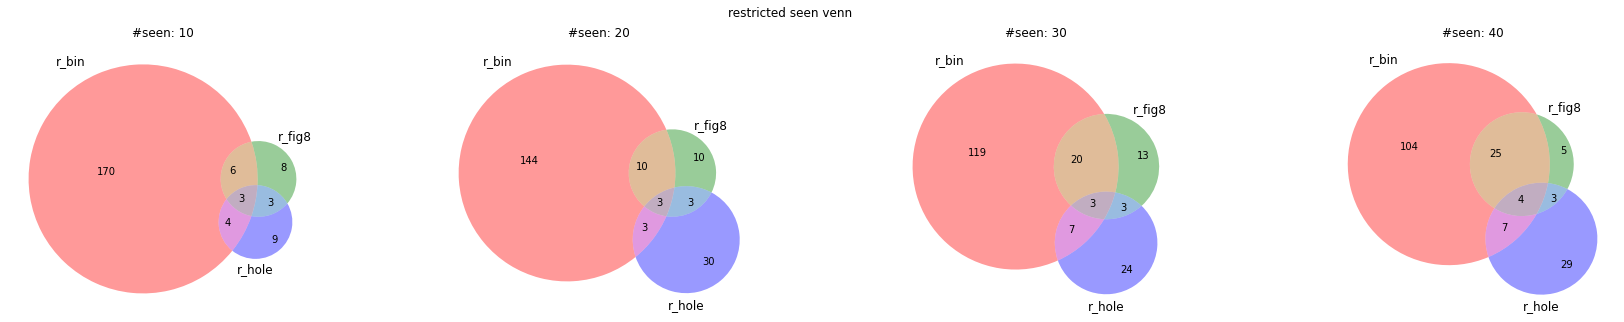

In [95]:
plt.close('all')
fig, axes = plt.subplots(1, 4, figsize=(30, 5))
fig.suptitle('restricted seen venn')
for x in range(4):
    res = results[x]
    venn3([res['rb'], res['r8'], res['rh']], set_labels=['r_bin', 'r_fig8', 'r_hole'], ax=axes[x])
    axes[x].set(title=f'#seen: {(x + 1) * 10}')

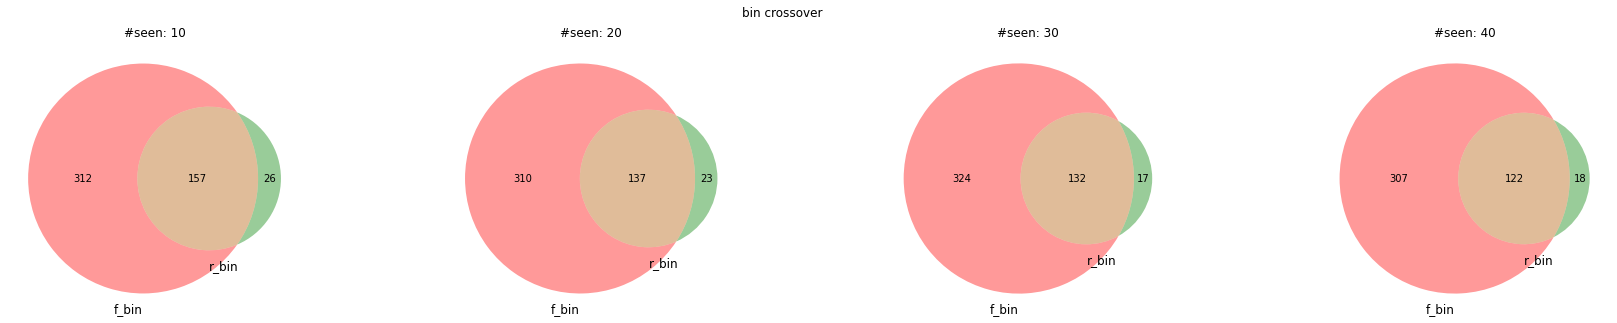

In [96]:
plt.close('all')
fig, axes = plt.subplots(1, 4, figsize=(30, 5))
fig.suptitle('bin crossover')
for x in range(4):
    res = results[x]
    venn2([res['fb'], res['rb']], set_labels=['f_bin', 'r_bin'], ax=axes[x])
    axes[x].set(title=f'#seen: {(x + 1) * 10}')

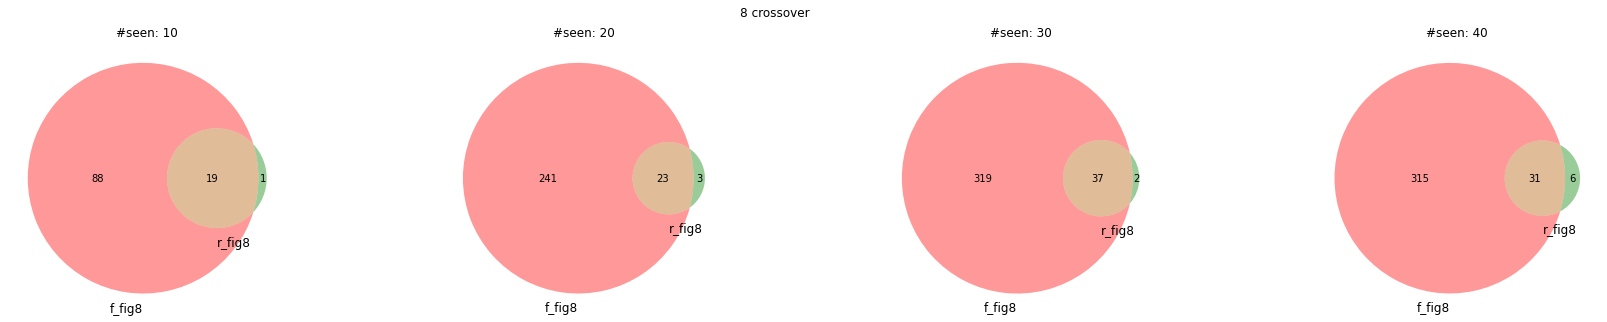

In [99]:
plt.close('all')
fig, axes = plt.subplots(1, 4, figsize=(30, 5))
fig.suptitle('8 crossover')
for x in range(4):
    res = results[x]
    venn2([res['f8'], res['r8']], set_labels=['f_fig8', 'r_fig8'], ax=axes[x])
    axes[x].set(title=f'#seen: {(x + 1) * 10}')

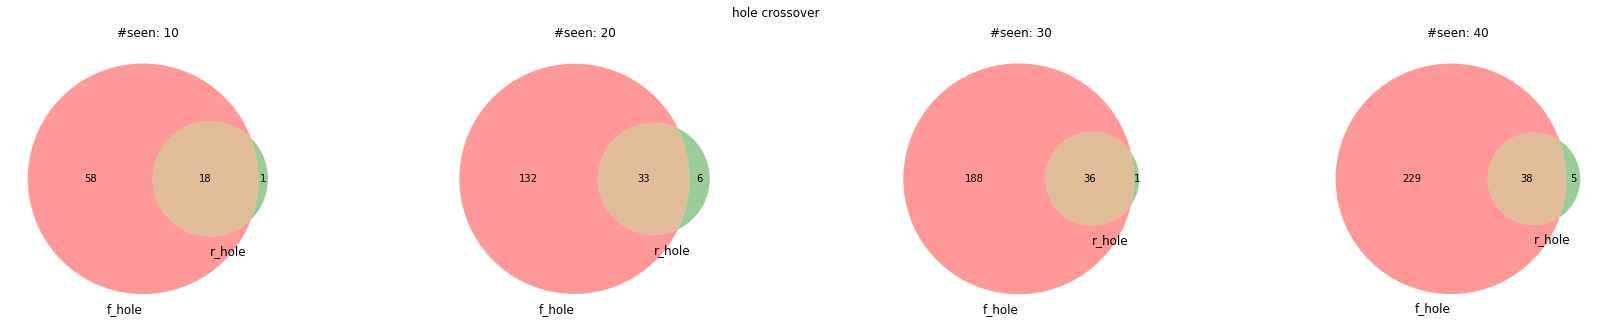

In [98]:
plt.close('all')
fig, axes = plt.subplots(1, 4, figsize=(30, 5))
fig.suptitle('hole crossover')
for x in range(4):
    res = results[x]
    venn2([res['fh'], res['rh']], set_labels=['f_hole', 'r_hole'], ax=axes[x])
    axes[x].set(title=f'#seen: {(x + 1) * 10}')

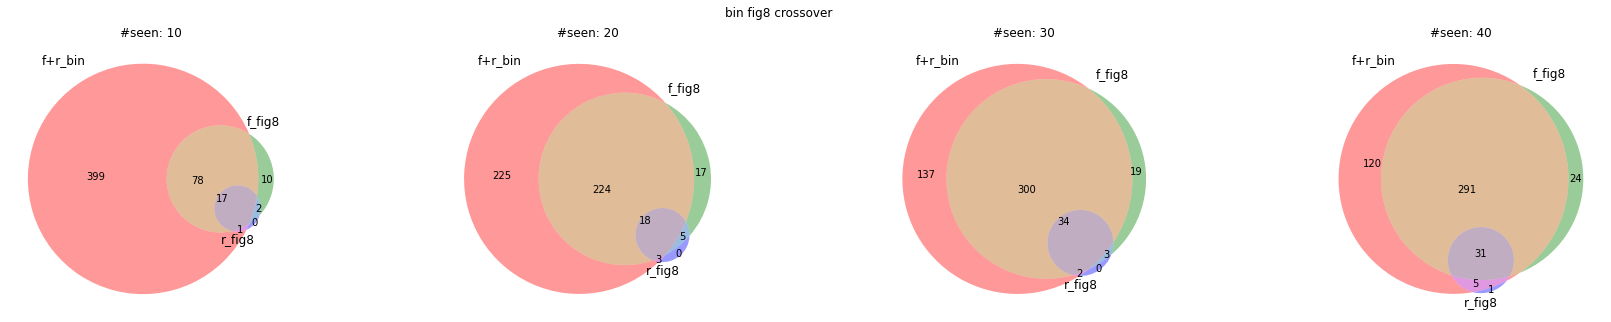

In [100]:
plt.close('all')
fig, axes = plt.subplots(1, 4, figsize=(30, 5))
fig.suptitle('bin fig8 crossover')
for x in range(4):
    res = results[x]
    venn3([res['b'], res['f8'], res['r8']], set_labels=['f+r_bin', 'f_fig8', 'r_fig8'], ax=axes[x])
    axes[x].set(title=f'#seen: {(x + 1) * 10}')

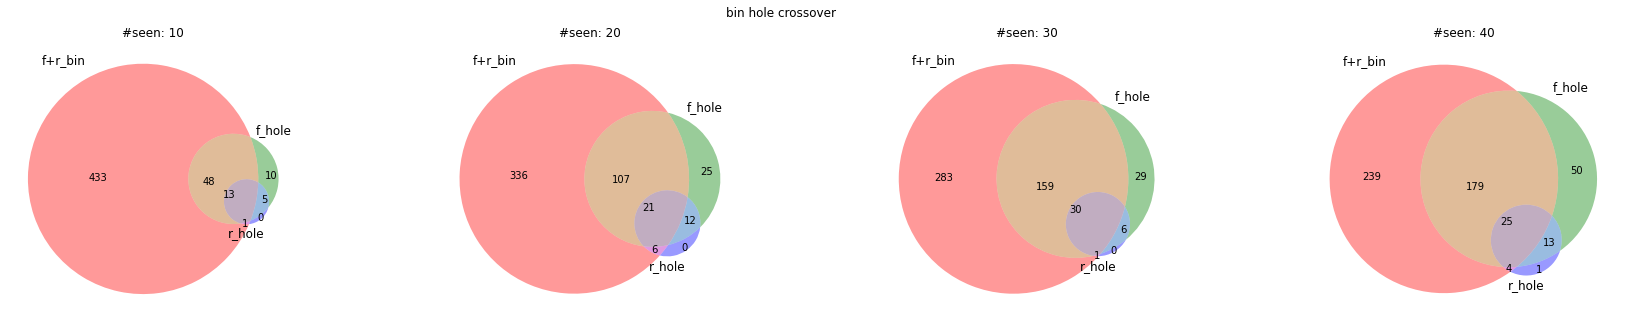

In [101]:
plt.close('all')
fig, axes = plt.subplots(1, 4, figsize=(30, 5))
fig.suptitle('bin hole crossover')
for x in range(4):
    res = results[x]
    venn3([res['b'], res['fh'], res['rh']], set_labels=['f+r_bin', 'f_hole', 'r_hole'], ax=axes[x])
    axes[x].set(title=f'#seen: {(x + 1) * 10}')

In [190]:
all_data = None
for x in range(4):
    e = ExpData.get_experiments(x)
    image_activations = np.load(e.image_activations)
    rd = RotationDataset(e)
    df = pd.read_csv(rd.testing.full.path.merged_annotation_path())
    df['model_code'] = df.model_name.astype(CategoricalDtype(categories=df.model_name.unique(),ordered=True)).cat.codes
    norm_image_activations = image_activations / np.max(image_activations, axis=0)
    in_hole = functools.reduce(lambda a, b: a | (df.object_x.between(*b[0]) & df.object_y.between(*b[1])), fig8_ranges, df.object_x > 10)
    df['in_bin'] = df.object_x.between(-0.25, 0.25) & df.object_y.between(-0.25, 0.25)
    df['in_hole'] = in_hole

    neural_cat_activations = np.zeros((3, 50, 512))
    for name, group in df.groupby('model_name'):
        neural_cat_activations[0, group.model_code.iloc[0]] = np.mean(norm_image_activations[group[group.in_bin].index], axis=0)
        neural_cat_activations[1, group.model_code.iloc[0]] = np.mean(norm_image_activations[group[~group.in_bin & ~group.in_hole].index], axis=0)
        neural_cat_activations[2, group.model_code.iloc[0]] = np.mean(norm_image_activations[group[~group.in_bin & group.in_hole].index], axis=0)

    norm_activity = normalize(neural_cat_activations.reshape(150, 512), axis=0, norm='l1')

    selectivity = np.zeros((150, 512))
    for y in range(512):
        a = norm_activity[:, y]
        b = np.argsort(a)[::-1]
        c = np.add.accumulate(a[b]) < 0.2
        selectivity[b[c], y] = 1
    
    selectivity = selectivity.reshape(3, 50, 512)

    f = np.any(selectivity[:,:40], axis=1)
    r = np.any(selectivity[:,:40], axis=1)

    fb = f[0]
    f8 = f[1]
    fh = f[2]

    rb = r[0]
    r8 = r[1]
    rh = r[2]

    data = pd.DataFrame({
        'bf': fb & ~f8 & ~fh & ~rb & ~r8 & ~rh,
        '8f': ~fb & f8 & ~fh & ~rb & ~r8 & ~rh,
        'hf': ~fb & ~f8 & fh & ~rb & ~r8 & ~rh,
        'b8f': fb & f8 & ~fh & ~rb & ~r8 & ~rh,
        'bhf': fb & ~f8 & fh & ~rb & ~r8 & ~rh,
        'b8hf': fb & f8 & fh & ~rb & ~r8 & ~rh,
        'br': ~fb & ~f8 & ~fh & rb & ~r8 & ~rh,
        '8r': ~fb & ~f8 & ~fh & ~rb & r8 & ~rh,
        'hr': ~fb & ~f8 & ~fh & ~rb & ~r8 & rh,
        'b8r': ~fb & ~f8 & ~fh & rb & r8 & ~rh,
        'bhr': ~fb & ~f8 & ~fh & rb & ~r8 & rh,
        'b8hr': ~fb & ~f8 & ~fh & rb & r8 & rh,
        'bfr': fb & ~f8 & ~fh & rb & ~r8 & ~rh,
        '8fr': ~fb & f8 & ~fh & ~rb & r8 & ~rh,
        'hfr': ~fb & ~f8 & fh & ~rb & ~r8 & rh,
        'b8fr': fb & f8 & ~fh & rb & r8 & ~rh,
        'bhfr': fb & ~f8 & fh & rb & ~r8 & rh,
        'bh8fr': fb & f8 & fh & rb & r8 & rh,
    })
    
    melted_data = data.melt()
    melted_data = melted_data[melted_data.value]
    
    melted_data['#seen'] = e.data_div
    if all_data is None:
        all_data = melted_data
    else:
        all_data = all_data.append(melted_data)
    print(f'done {x}')

done 0
done 1
done 2
done 3


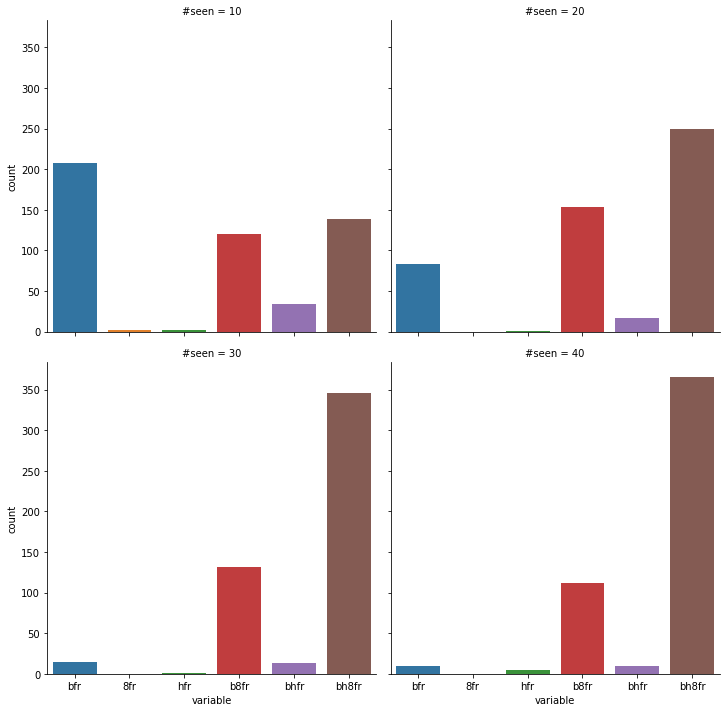

In [191]:
sns.catplot(kind='count', col='#seen', x='variable', data=all_data, col_wrap=2)